In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
fake = pd.read_csv('Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [18]:
true = pd.read_csv('True.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [19]:
fake["class"] = 0
true["class"] = 1

In [20]:
fake = fake.drop(["title", "subject","date"], axis = 1)
true = true.drop(["title", "subject","date"], axis = 1)

In [21]:
fake.isnull().sum()
true.isnull().sum()

,0
text,0
class,0


In [22]:
data = pd.concat([fake,true], axis = 0)
data.head()

,text,class
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [23]:
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)
data.head()

,text,class
0,"BOGOR/JAKARTA, Indonesia (Reuters) - Few villa...",1
1,"Apparently, Kimmel s okay with throwing half o...",0
2,Ashleigh Shackelford is what passes for a seri...,0
3,Donald Trump held a bizarre press conference T...,0
4,DUBAI (Reuters) - A Bahraini civil society gro...,1


<Axes: xlabel='class', ylabel='count'>

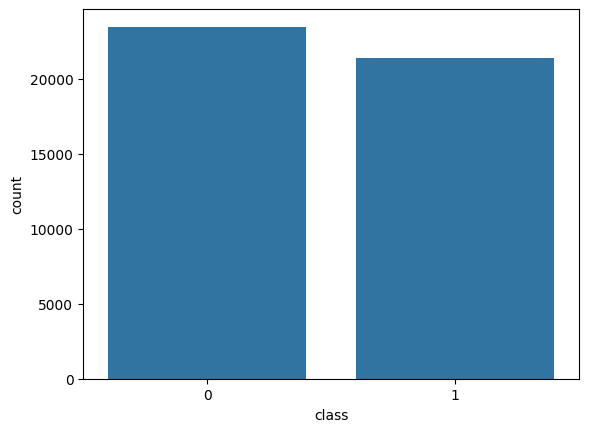

In [24]:
sns.countplot(data=data, x='class', order=data['class'].value_counts().index)

In [25]:
data.shape

(44898, 2)

In [26]:
def preprocess_text(text_data):
    preprocessed_text = []
    for sentence in tqdm(text_data):

        # Remove punctuation from the sentence using a regular expression
        sentence = re.sub(r'[^\w\s]', '', sentence)

        # Tokenize the sentence, convert tokens to lowercase, and remove stopwords
        # 'sentence.split()' splits the sentence into words (tokens)
        # 'token.lower()' converts each token to lowercase
        # 'if token not in stopwords.words('english')' filters out stopwords
        processed_sentence = ' '.join(
            token.lower() for token in str(sentence).split()
            if token not in stopwords.words('english')
        )

        preprocessed_text.append(processed_sentence)

    return preprocessed_text

In [27]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review
data.head()

100%|██████████| 44898/44898 [35:43<00:00, 20.95it/s]


,text,class
0,bogorjakarta indonesia reuters few villagers l...,1
1,apparently kimmel okay throwing half audience ...,0
2,ashleigh shackelford passes serious democrat d...,0
3,donald trump held bizarre press conference tue...,0
4,dubai reuters a bahraini civil society group d...,1


In [30]:

def visualize_word_cloud(i):
    # Consolidate all text from rows where 'class' equals 1 and 0 into a single string
    consolidated = ' '.join(
        word for word in data['text'][data['class'] == i].astype(str)
    )

    # Create a WordCloud object with specific settings
    wordCloud = WordCloud(
        width=1600,          # Width of the WordCloud image
        height=800,          # Height of the WordCloud image
        random_state=21,     # Random seed for reproducibility
        max_font_size=110,   # Maximum font size for the largest words
        collocations=False   # Do not allow word collocations (word pairs)
    )

    # Visualization section
    plt.figure(figsize=(15, 10))
    # Generate the WordCloud from the consolidated text and display it
    plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
    plt.axis('off')
    plt.show()

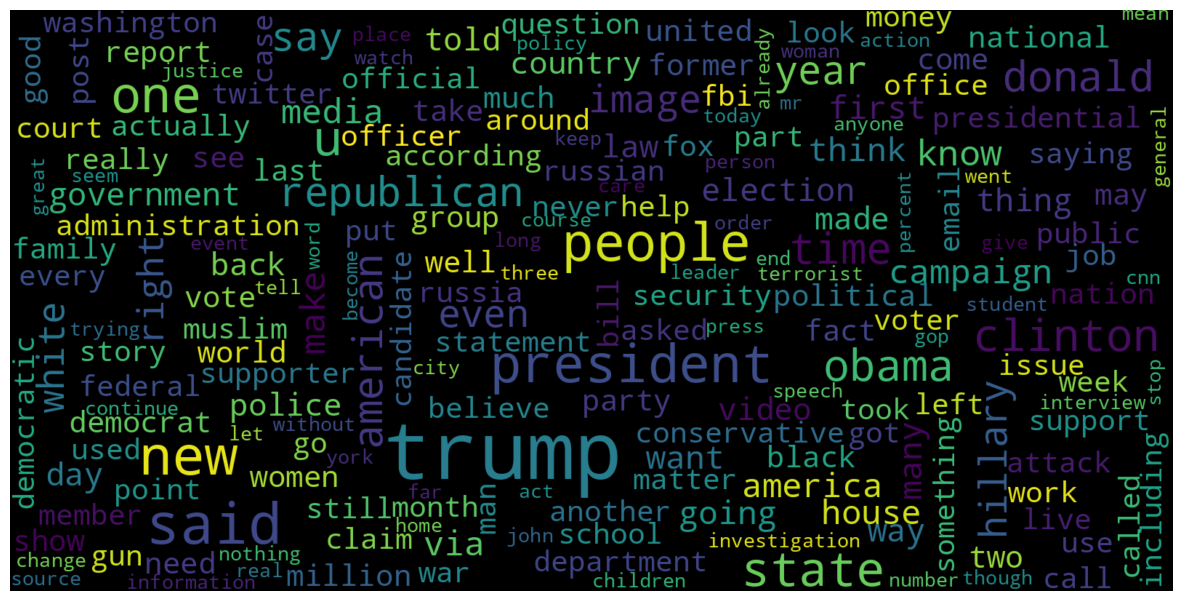

In [31]:
# Fake
visualize_word_cloud(0)

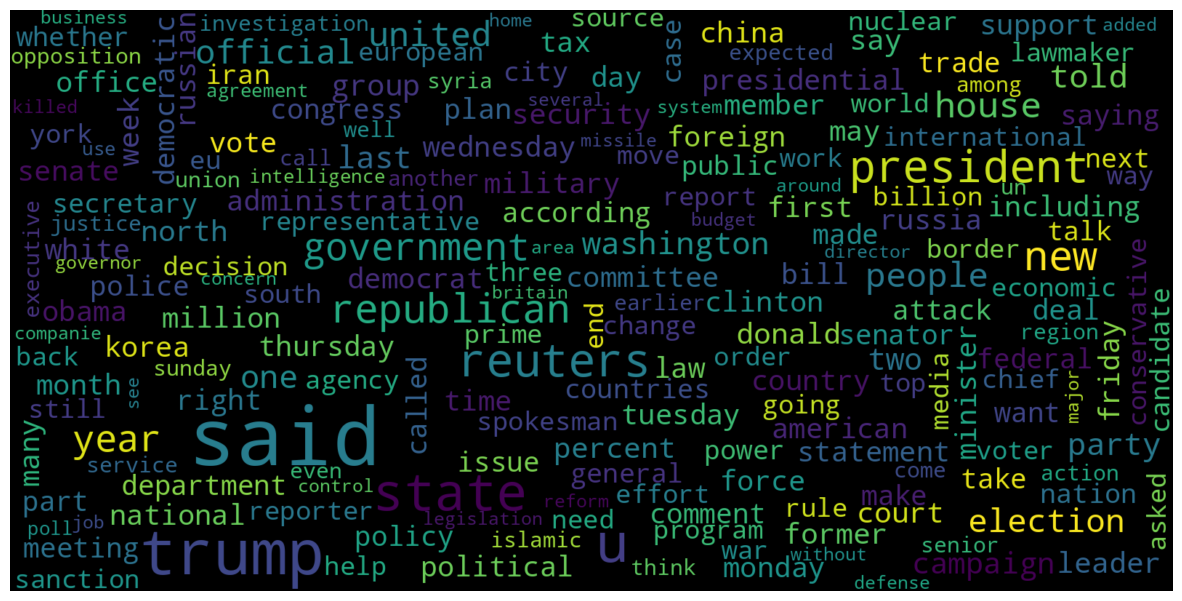

In [32]:
# True
visualize_word_cloud(1)

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

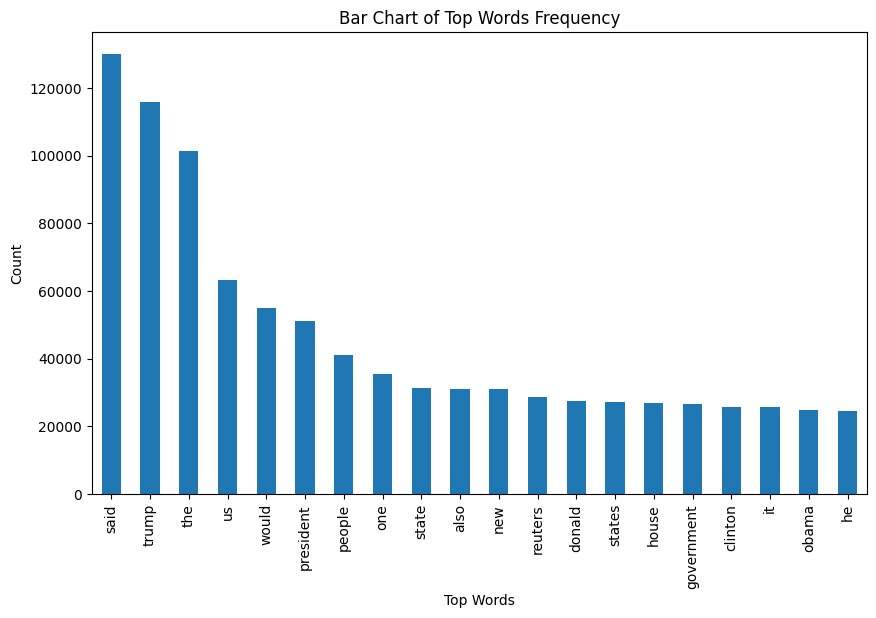

In [34]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [36]:
x_train, x_test, y_train, y_test = train_test_split(data['text'], data['class'], test_size=0.25)

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


In [38]:
vectorizer = TfidfVectorizer()
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

model = DecisionTreeClassifier()
model.fit(x_train_vec, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train_vec)))
print(accuracy_score(y_test, model.predict(x_test_vec)))

0.9999703026163395
0.9960801781737194


In [39]:
from sklearn import metrics

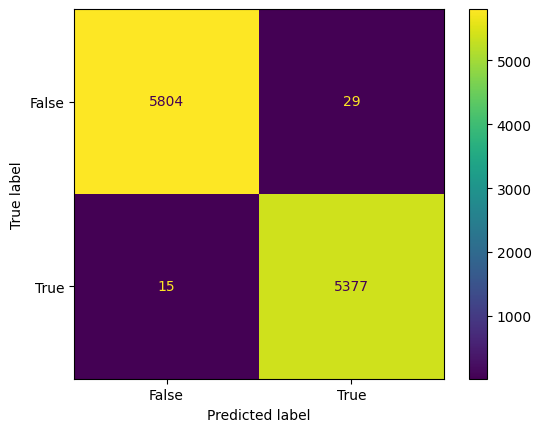

In [40]:
cm = metrics.confusion_matrix(y_test, model.predict(x_test_vec))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])

cm_display.plot()
plt.show()

In [41]:
# Test using real news source
def fake_news_det(text):
    input_data = [text]
    vectorized_input_data = vectorizer.transform(input_data)
    prediction = model.predict(vectorized_input_data)
    if prediction == 1:
        print("The news is real")
    else:
        print("The news is fake")
    return prediction

In [42]:
text = """
BUTLER, Pennsylvania, Oct 5 (Reuters) - Republican presidential candidate Donald Trump on Saturday returned to the rural Pennsylvania site where he was nearly assassinated, rallying a large crowd in the critical battleground state one month before the Nov. 5 election.
"As I was saying," Trump said as he appeared on stage, pretending he was resuming the speech that was interrupted when he was grazed in the ear by a bullet on July 13.
In mid-speech Trump called up on stage a powerful ally, Elon Musk, CEO of Tesla and owner of social media platform X. It was his first time at a Trump campaign event since he endorsed the former president after July 13.
Musk literally jumped up on stage with his arms held high.
"The true test of someone's character is how they behave under fire," Musk said, calling the election a "must-win situation" for Trump and urging the crowd to register to vote.
"Be a pest to everyone you know," Musk said.
Trump saluted firefighter Corey Comperatore, who was shot and killed by the shooter, and two other people who were wounded.
At 6:11 p.m., the exact time when gunfire erupted on July 13, Trump called for a moment of silence. A bell then tolled four times, once for each of the four victims, including Trump.
In his speech, Trump hinted darkly without evidence about facing "an enemy from within" more dangerous than a foreign adversary. Of the gunman, he said "a cold-blooded assassin aimed to silence me" but "did not stop our movement."
The crowd appeared to be in the tens of thousands, many wearing Trump regalia. Some chanted the "fight, fight, fight" slogan Trump used to rally his followers moments after he was shot.
"We're here to say, we can't be intimidated, we can't be stopped," Ohio Republican Senator JD Vance, Trump's vice presidential running mate, told the crowd.
Vance rejected the argument from Vice President Kamala Harris and other Democrats that Trump represents a threat to democracy.
"Donald Trump took a bullet for democracy. What the hell have you done?" Vance said.
Item 1 of 12 Tesla CEO and X owner Elon Musk speaks as Republican presidential nominee and former U.S. president Donald Trump looks on during a campaign rally, at the site of the July assassination attempt against Trump, in Butler, Pennsylvania, U.S., October 5, 2024. REUTERS/Brian Snyder
[1/12]Tesla CEO and X owner Elon Musk speaks as Republican presidential nominee and former U.S. president Donald Trump looks on during a campaign rally, at the site of the July assassination attempt against Trump, in Butler, Pennsylvania, U.S., October 5, 2024. REUTERS/Brian Snyder Purchase Licensing Rights
, opens new tab
People cheered when Trump's plane did a flyby over the rally prior to landing as the loudspeakers played the "Top Gun" movie theme song.
Trailers were lined up around the site as a protective measure to block the surrounding view including the building where the shooter had opened fire.
Adding to the carnival-like atmosphere, three parachutists with American flags streaming behind them hurtled down and landed near the building.
July 13 was the first of two attempts on Trump's life. On Sept. 15, a gunman hid undetected for nearly 12 hours at Trump's golf course in West Palm Beach, Florida, with plans to kill him, prosecutors have said, but was thwarted by a U.S. Secret Service agent patrolling the course ahead of Trump.
Republican officials hope Trump's return to Butler will drive up turnout for him among hard-core supporters in Pennsylvania, a state he and his Democratic opponent, Kamala Harris, see as crucial to winning on Nov. 5.
"I'm going back to Butler because I feel I have an obligation to go back to Butler," Trump told the NewsNation cable news network earlier this week. "We never finished what we were supposed to do."
Introductory speakers at the rally focused on remembering Comperatore, whose family members attended.
"We will not let that tragic day overshadow our community's light," said JD Longo, mayor of the nearby town of Slippery Rock.
The Butler shooting led to widespread criticism of the U.S. Secret Service and the resignation of its director.
Critics raised concerns about how the 20-year-old suspect, Thomas Matthew Crooks was able to access a nearby rooftop with a direct line of sight to where Trump was speaking. Crooks was subsequently shot to death by Secret Service agents.
A Secret Service probe found communication gaps and a lack of diligence ahead of the shooting. In its aftermath, the agency approved extra security measures for Trump, including using bulletproof glass to shield him at outdoor rallies.
Secret Service spokesperson Anthony Guglielmi said in a statement before Saturday's rally that there had been "comprehensive changes and enhancements to our communications capabilities, resourcing and protective operations."
Trump credits turning his head to read a chart on a big video as having saved his life. With blood dripping down his face, he raised a fist and shouted "fight" to his supporters, a vivid image from that day. He wore a white bandage on his wounded ear for days afterward.
"I love that chart," Trump said when it flashed on screen on Saturday. "Isn't it beautiful?"
"""
fake_news_det(text)

The news is real


array([1])

In [43]:
text = """
    Lorem ipsum dolor sit amet consectetur, adipisicing elit.
    Quasi quod, labore, recusandae quas hic impedit amet accusantium non ad provident, ipsam at.
    Excepturi blanditiis sunt ea ullam aliquid, quos neque architecto sequi.
    Odio facilis deleniti atque ab, perferendis ipsam accusantium cumque iste
    nesciunt pariatur dolores suscipit corporis earum consectetur ipsum temporibus.
    Aliquid neque ratione ipsam alias dolor perspiciatis eos ipsa asperiores eum.
    Officia architecto quod amet dolore at placeat provident reiciendis libero quis,
    aut mollitia itaque veritatis vero sunt pariatur saepe et nisi,
    perferendis molestiae ipsam commodi error blanditiis ea ex.
    Aut, eius eos voluptates, quidem ipsa tempore sint fugiat aspernatur blanditiis
    nemo facere id eveniet! Animi magni hic unde, vero alias, dolorum repudiandae,
    eveniet aut omnis aliquam eaque quis vitae quod consequuntur placeat dicta illum voluptatum labore!
    Corrupti adipisci obcaecati explicabo ab odio unde tenetur odit laudantium,
    eius doloremque esse nesciunt qui veritatis sapiente voluptates necessitatibus
    impedit sunt architecto fugiat magnam incidunt tempora veniam.
    Similique distinctio tempora iure vero odio nulla optio qui cumque dicta unde est repudiandae quasi in dolorem,
    minima tempore eaque corporis illo amet repellendus placeat rerum, iusto beatae voluptates.
    Optio, modi unde? Molestiae, at ipsa! Libero, quidem asperiores quaerat soluta magnam iste.
    Rerum dolor voluptate praesentium voluptates! Id quia asperiores inventore iste voluptates est eius.
    Nostrum voluptatum minima iste dolores neque aperiam eaque obcaecati harum tempora, inventore,
    reiciendis aliquam ex quas eligendi voluptates dolorum placeat laboriosam. Nulla officia voluptatum unde
"""

fake_news_det(text)

The news is fake


array([0])

In [44]:
import pickle

with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

print("Model and vectorizer saved!")


Model and vectorizer saved!
